In [1]:
# Step 1: Importing Libraries
import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths to dataset
train_dir = "../../data4/train"       # Replace with your train dataset folder
validation_dir = "../../data4/validation"  # Replace with your validation dataset folder
test_dir = "../../data4/test"         # Replace with your test dataset folder


In [2]:
# Step 2: Load ResNet50 for Feature Extraction
# Load pre-trained ResNet50 without the top (fully connected) layers
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Feature extraction function
def extract_features(directory, model, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    # Extract features
    features = model.predict(generator, verbose=1)
    labels = generator.classes  # Get class labels
    return features, labels

# Extract features for training, validation, and test datasets
train_features, train_labels = extract_features(train_dir, resnet)
validation_features, validation_labels = extract_features(validation_dir, resnet)
test_features, test_labels = extract_features(test_dir, resnet)

# Flatten features for traditional models (convert to 2D array)
train_features_flat = train_features.reshape(train_features.shape[0], -1)
validation_features_flat = validation_features.reshape(validation_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Combine train and validation sets for final training
X_train = np.vstack((train_features_flat, validation_features_flat))
y_train = np.hstack((train_labels, validation_labels))
X_test = test_features_flat
y_test = test_labels


Found 5999 images belonging to 4 classes.


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step
Found 1672 images belonging to 4 classes.
53/53 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step
Found 1672 images belonging to 4 classes.
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


In [3]:
# Step 3: Standardize Features
# Scale features for KNN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


KNN Accuracy: 0.6196172248803827

Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.52      0.50      0.51       450
           1       0.58      0.62      0.60       450
           2       0.65      0.50      0.56       322
           3       0.72      0.83      0.77       450

    accuracy                           0.62      1672
   macro avg       0.62      0.61      0.61      1672
weighted avg       0.62      0.62      0.61      1672



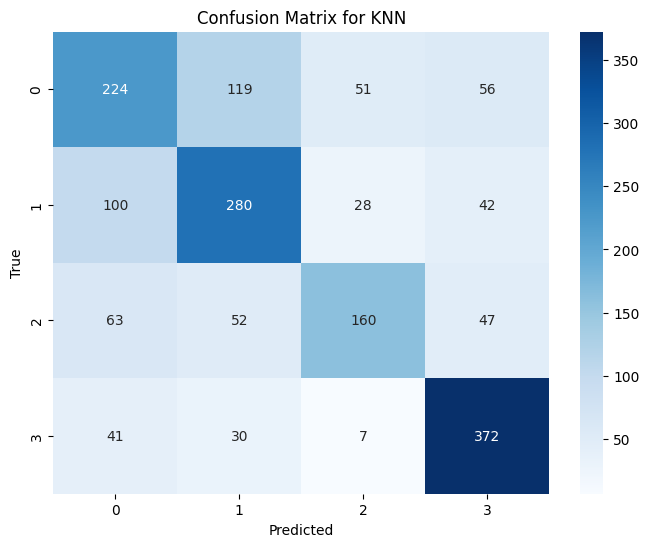

In [4]:
# Step 4: K-Nearest Neighbors (KNN)
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluate KNN model
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)
print("\nClassification Report (KNN):\n", classification_report(y_test, knn_predictions))

# Confusion Matrix for KNN
knn_cm = confusion_matrix(y_test, knn_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Random Forest Accuracy: 0.7260765550239234

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.63      0.67      0.65       450
           1       0.73      0.69      0.71       450
           2       0.67      0.79      0.72       322
           3       0.89      0.78      0.83       450

    accuracy                           0.73      1672
   macro avg       0.73      0.73      0.73      1672
weighted avg       0.74      0.73      0.73      1672



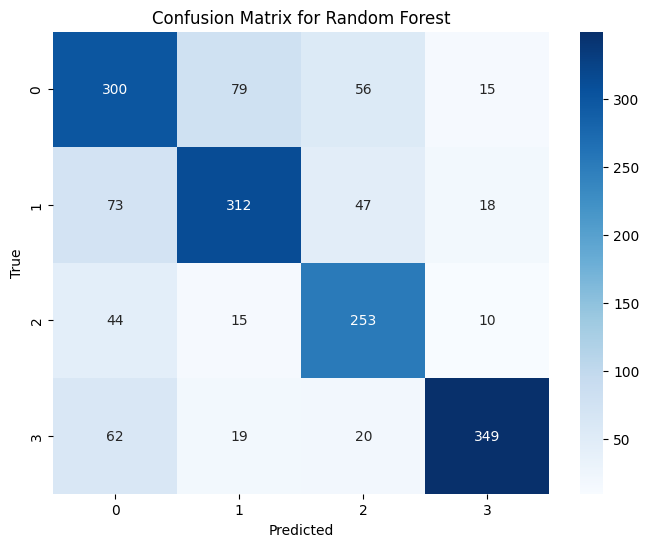

In [5]:
# Step 5: Random Forest
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate Random Forest model
rf_predictions = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print("\nClassification Report (Random Forest):\n", classification_report(y_test, rf_predictions))

# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


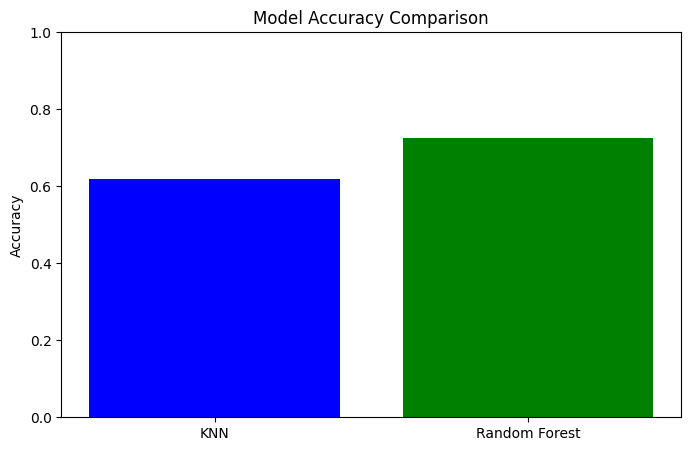

In [6]:
# Step 6: Compare Model Performances
# Compare KNN and Random Forest
models = ['KNN', 'Random Forest']
accuracies = [knn_accuracy, rf_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


In [7]:
import joblib

# Save the KNN model
joblib.dump(knn, '../../models/improved_knn_model.pkl')

# Save the Random Forest model
joblib.dump(rf, '../../models/improved_random_forest_model.pkl')

print("Models saved successfully!")


Models saved successfully!


In [8]:
# Load the saved models
knn = joblib.load('../../models/improved_knn_model.pkl')
rf = joblib.load('../../models/improved_random_forest_model.pkl')

print("Models loaded successfully!")


Models loaded successfully!


In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_disease(image_path, model, scaler=None, class_labels=None):
    """
    Predict the disease from an image using a trained model (KNN or Random Forest).
    
    Args:
        image_path (str): Path to the image.
        model: Trained classification model (KNN or Random Forest).
        scaler: Scaler used to normalize features (optional, for KNN).
        class_labels (dict): Mapping of class indices to class names.
        
    Returns:
        prediction (str): Predicted class label (name).
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Extract features using ResNet50
    resnet_features = resnet.predict(img_array)
    resnet_features_flat = resnet_features.reshape(1, -1)
    
    # Scale features if necessary (for KNN)
    if scaler:
        resnet_features_flat = scaler.transform(resnet_features_flat)
    
    # Make a prediction
    prediction = model.predict(resnet_features_flat)
    predicted_class_index = prediction[0]  # Extract the predicted class index
    
    # Map class index to class name
    if class_labels:
        predicted_class = class_labels.get(predicted_class_index, "Unknown Class")
    else:
        predicted_class = str(predicted_class_index)  # Fallback to index if no mapping provided
    
    return predicted_class


In [13]:
# Path to the new image
new_image_path = "../../data4/test/3. Akne/2 (7)1.jpg"

# Predict with KNN
knn_prediction = predict_disease(new_image_path, knn, scaler=scaler)
print(f"KNN Prediction: {knn_prediction}")

# Predict with Random Forest
rf_prediction = predict_disease(new_image_path, rf)
print(f"Random Forest Prediction: {rf_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
KNN Prediction: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Random Forest Prediction: 2


In [14]:
from joblib import dump, load
# Step 3: Standardize Features
# Scale features for KNN
scaler = StandardScaler()
Xd_train = scaler.fit_transform(X_train)
Xd_test = scaler.transform(X_test)


# import numpy as np

# # Save the scaled data to different files
# np.save("../../models/X_train_scaled.npy", Xd_train)
# np.save("../../models/X_test_scaled.npy", Xd_test)
# Save scaler after training
       # Transform test data
dump(scaler, "../../models/scaler.joblib")        



